In [1]:
import numpy as np
from numpy import pi
from numpy import linalg
from numpy.core.fromnumeric import reshape, trace
from numpy.lib.function_base import meshgrid
from numpy.lib.nanfunctions import nanquantile
from numpy.lib.polynomial import RankWarning
from numpy.linalg import eig as eig
from numpy.linalg.linalg import norm
from scipy.special import erf
from matplotlib import pyplot as plt

from pyscf import gto , scf, cc ,mp
from matplotlib import pyplot as plt
import pyscf

plt.rcParams["savefig.dpi"]=900
plt.rcParams["figure.dpi"]=900

In [2]:
###HW1

phiH=np.array([[0.3425250914E+01,0.1543289673E+00],[0.6239137298E+00, 0.5353281423E+00],[0.1688554040E+00,0.4446345422E+00]])

phiHe=np.array([[0.6362421394E+01,0.1543289673E+00],[0.1158922999E+01,0.5353281423E+00],[0.3136497915E+00,0.4446345422E+00]])

RH=0
RHe=1.4632


def Solver(N=2,phi=[phiH,phiHe],R=[RH,RHe],Z=[1,2],output=True):
    if N%2!=0:
        raise Exception("No suitable for RHF")
    K=len(phi)
    (C,e)=initial(K)
    #K:number of orbit N:number of electron C:K*K,e:K*1
    err=1E-9
    E=min(e)
    (S,T,V,I)=generate(phi,R,R,Z,K)
    epoch=1
    while True:
        if output:
            print("epoch=%d"%epoch)
        p=P(C,N//2)
        G=np.einsum("lk,ijkl",p,I)-1/2*np.einsum("lk,ilkj",p,I)
        F=T+V+G
        (C,e)=update(S,F)
        Enew=min(e)
        cnew=C[:,e==Enew]
        Eorbit=np.trace(np.dot(cnew.conj().T,np.dot(2*(T+V)+G,cnew)))
        Etot=Eorbit+Z[0]*Z[1]/abs(R[0]-R[1])
        if output:
            print("total energy=%.12f,orbit enery=%.12f"%(Etot,Eorbit))
        if abs(Etot-E)<err:
            if output:
                print("Converge criterion:%.1e"%err)
            return Etot,cnew
        else:
            E=Etot
            epoch+=1
            
def density(x,y,c,phi,R,n=2):
    # matrix 
    #r: k*l matrix
    K=len(phi)
    phir=np.zeros((len(x),len(y),K))
    for i in range(K):
        phir[:,:,i]=phi_wavefunction(x,y,phi[i],R[i])
    phimunu=phir.reshape((len(x),len(y),K,1))*phir.reshape((len(x),len(y),1,K))
    #phimur: mu,r matrix phinu nu,r P:mu*nu
    return np.einsum("ij,klji",P(c,n//2),phimunu)

def phi_wavefunction(x,y,phii,Ri):
    (X,Y)=np.meshgrid(x,y)
    amplitude=0
    for coeff in phii:
        amplitude+=np.exp(-coeff[0]*((X-Ri)**2+Y**2))
    return amplitude

def initial(K):
    #cof=np.identity(K)
    #cof=np.zeros((K,K))
    #cof=np.ones((K,K))
    cof=np.array([[0,0],[0,0]])
    E=np.zeros(K)
    return (cof,E)


def generate(phi,R,RI,Z,K):
    Sij=np.zeros((K,K))
    Tij=np.zeros((K,K))
    Vij=np.zeros((K,K))
    Iijkl=np.zeros((K,K,K,K))
    for i in range(K):
        for j in range(K):
            phi1=phi[i]
            phi2=phi[j]
            d1=phi1[:,1]
            d2=phi2[:,1]
            R1=R[i]
            R2=R[j]
            (a,b)=np.meshgrid(phi1[:,0],phi2[:,0])
            sab=s(a,b,R1,R2)
            Sij[i][j]=np.dot(d1.conj(),np.dot(sab,d2))
            Tij[i][j]=np.dot(d1.conj(),np.dot(t(a,b,R1,R2,sab),d2))
            Vij[i][j]=np.dot(d1.conj(),np.dot(v(a,b,R1,R2,sab,Z,RI),d2))
            for k in range(2):
                for l in range(2):
                    phi3=phi[k]
                    phi4=phi[l]
                    d3=phi3[:,1]
                    d4=phi4[:,1]
                    R3=R[k]
                    R4=R[l]
                    (c,d)=np.meshgrid(phi3[:,0],phi4[:,0])
                    scd=s(c,d,R3,R4)
                    Iijkl[i][j][k][l]=np.einsum("ijkl,i,j,k,l",interaction(a,b,c,d,R1,R2,R3,R4,sab,scd),d1.conj(),d2,d3.conj(),d4)

    #print("V",Vij)
    #print("T",Tij)
    #print("I",Iijkl)
    return (Sij,Tij,Vij,Iijkl)


def P(c,n):
    c_occ=c[:,0:n]
    #K*N
    return 2*np.dot(c_occ,np.transpose(c_occ.conj()))


def s(alpha,beta,R1,R2):
    return (4*alpha*beta/(alpha+beta)**2)**(3/4)*np.exp(-alpha*beta/(alpha+beta)*abs(R1-R2)**2)

def t(alpha,beta,R1,R2,s):
    return (3*alpha*beta/(alpha+beta)-2*((alpha*beta)/(alpha+beta))**2*abs(R1-R2)**2)*s

def v(alpha,beta,R1,R2,s,Z,RI):
    RP=(alpha*R1+beta*R2)/(alpha+beta)
    Nnucle=len(Z)
    vi=0
    for i in range(Nnucle):
        cond=np.zeros_like(RP)
        cond[np.abs(RP-RI[i])<1E-8]=1
        vi=vi-2*Z[i]*np.sqrt((alpha+beta)/pi)*s*cond-Z[i]*erf(np.sqrt(alpha+beta)*abs(RP-RI[i]))/(abs(RP-RI[i])+1E-12)*s*(1-cond)
    return vi

def interaction(alpha,beta,gamma,delta,R1,R2,R3,R4,s1,s2):
    sshape=np.shape(s1)
    s1=np.reshape(s1,(sshape[0],sshape[1],1,1))
    s2=np.reshape(s2,(1,1,sshape[0],sshape[1]))
    a=np.reshape(alpha,(sshape[0],sshape[1],1,1))
    b=np.reshape(beta,(sshape[0],sshape[1],1,1))
    c=np.reshape(gamma,(1,1,sshape[0],sshape[1]))
    d=np.reshape(delta,(1,1,sshape[0],sshape[1]))
    RQ=(c*R3+d*R4)/(c+d)
    RP=(a*R1+b*R2)/(a+b)
    alphat=(a+b)*(c+d)/(a+b+c+d)
    cond=np.zeros_like(RP-RQ)
    cond[np.abs(RP-RQ)<1E-8]=1
    return cond*2*s1*s2*np.sqrt(alphat/np.pi)+(1-cond)*s1*s2*erf(np.sqrt(alphat)*abs(RP-RQ))/(abs(RP-RQ)+1E-12)

def update(S,F):
    (s,U)=eig(S)
    X=np.dot(U,np.diag(s**(-0.5)))
    FF=np.dot(np.dot(X.T.conj(),F),X)
    #print("FF",FF)
    (e,CC)=eig(FF)
    C=np.dot(X,CC)
    order=np.argsort(e)
    e=e[order]
    C=C[:,order]
    return (C,e)


def H2molecular():
    e=[]
    x=np.arange(0.5,8,0.1)
    for i in x:
        (ee,psi)=Solver(2,[phiH,phiH],[0,i],[1,1],output=False)
        print("H2 molecur(R=%f)\ttotal energy=%.12f"%(i,ee))
        e.append(ee)

    plt.plot(x,e)
    plt.xlabel("distance/Bohr")
    plt.ylabel("Total energy/Hatree")
    plt.title("Energy curve of H2 molecular")
    plt.savefig("H2.png")
    plt.show()

def HeH():
    L=3
    NN=60
    (ehe,che)=Solver()
    ra=np.arange(-L,L,L/NN)
    plt.imshow(density(ra,ra,che,[phiH,phiHe],[RH,RHe]))
    plt.colorbar()
    plt.scatter([NN,NN+1.4632/L*NN],[NN,NN],s=3)
    plt.xticks(np.arange(0,2*NN,NN/5),np.round(np.arange(-L,L,L/5),2))
    plt.yticks(np.arange(0,2*NN,NN/5),np.round(np.arange(-L,L,L/5),2))
    plt.savefig("densityHeH.png")

In [4]:
Solver(N=2,phi=[phiH,phiH],R=[RH,1.200],Z=[1,1],output=False)

(-1.110333882489139, array([[0.53781331],
        [0.53781331]]))

-------------------------------------------------------
H2 molecur(R=0.500000)	total energy=-0.403326439277
H2 molecur(R=0.600000)	total energy=-0.668256409232
H2 molecur(R=0.700000)	total energy=-0.837130296740
H2 molecur(R=0.800000)	total energy=-0.947307929983
H2 molecur(R=0.900000)	total energy=-1.019497055134
H2 molecur(R=1.000000)	total energy=-1.065999461551
H2 molecur(R=1.100000)	total energy=-1.094564097779
H2 molecur(R=1.200000)	total energy=-1.110333882489
H2 molecur(R=1.300000)	total energy=-1.116871140422
H2 molecur(R=1.400000)	total energy=-1.116714325172
H2 molecur(R=1.500000)	total energy=-1.111695893595
H2 molecur(R=1.600000)	total energy=-1.103140970808
H2 molecur(R=1.700000)	total energy=-1.092005849431
H2 molecur(R=1.800000)	total energy=-1.078982212390
H2 molecur(R=1.900000)	total energy=-1.064576878660
H2 molecur(R=2.000000)	total energy=-1.049170902570
H2 molecur(R=2.100000)	total energy=-1.033060857658
H2 molecur(R=2.200000)	total energy=-1.016485722190
H2 molec

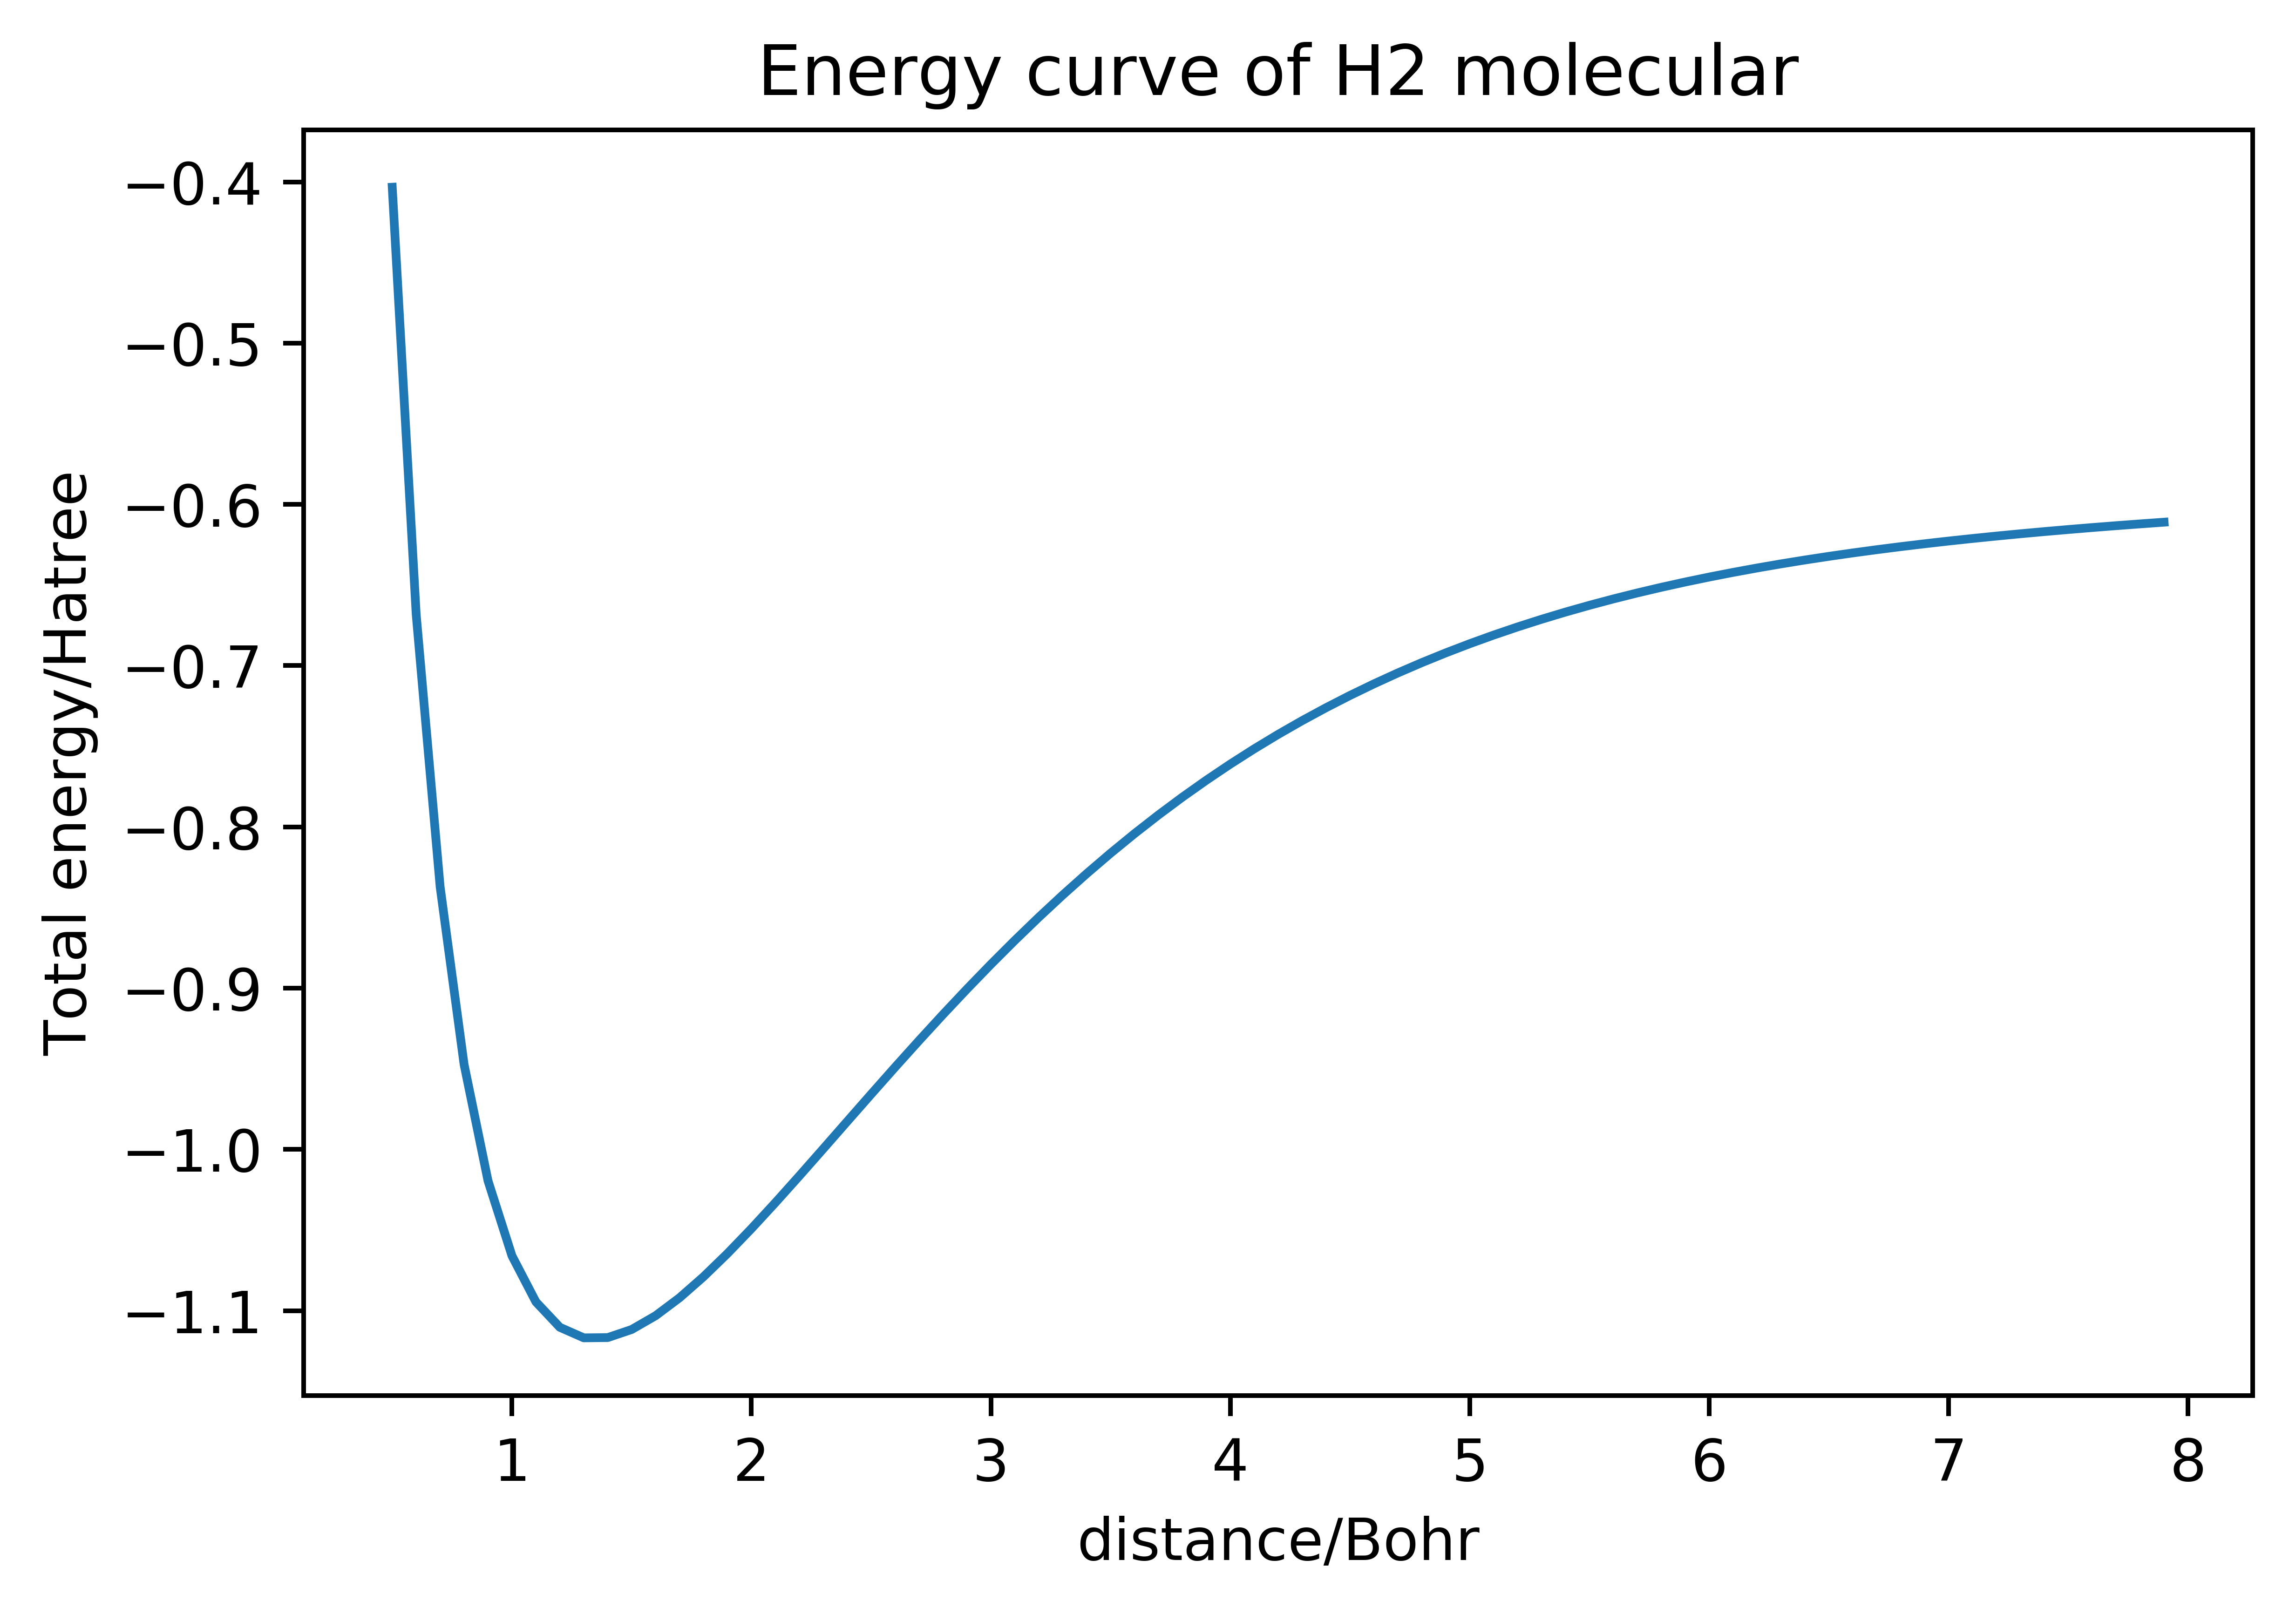

-------------------------------------------------------
epoch=1
total energy=-3.832719936049,orbit enery=-5.199587076563
epoch=2
total energy=-2.799223490776,orbit enery=-4.166090631290
epoch=3
total energy=-2.834525262149,orbit enery=-4.201392402663
epoch=4
total energy=-2.840693233116,orbit enery=-4.207560373630
epoch=5
total energy=-2.841660561262,orbit enery=-4.208527701776
epoch=6
total energy=-2.841809490707,orbit enery=-4.208676631221
epoch=7
total energy=-2.841832353557,orbit enery=-4.208699494071
epoch=8
total energy=-2.841835861775,orbit enery=-4.208703002289
epoch=9
total energy=-2.841836400061,orbit enery=-4.208703540575
epoch=10
total energy=-2.841836482653,orbit enery=-4.208703623167
epoch=11
total energy=-2.841836495325,orbit enery=-4.208703635839
epoch=12
total energy=-2.841836497270,orbit enery=-4.208703637784
epoch=13
total energy=-2.841836497568,orbit enery=-4.208703638082
Converge criterion:1.0e-09


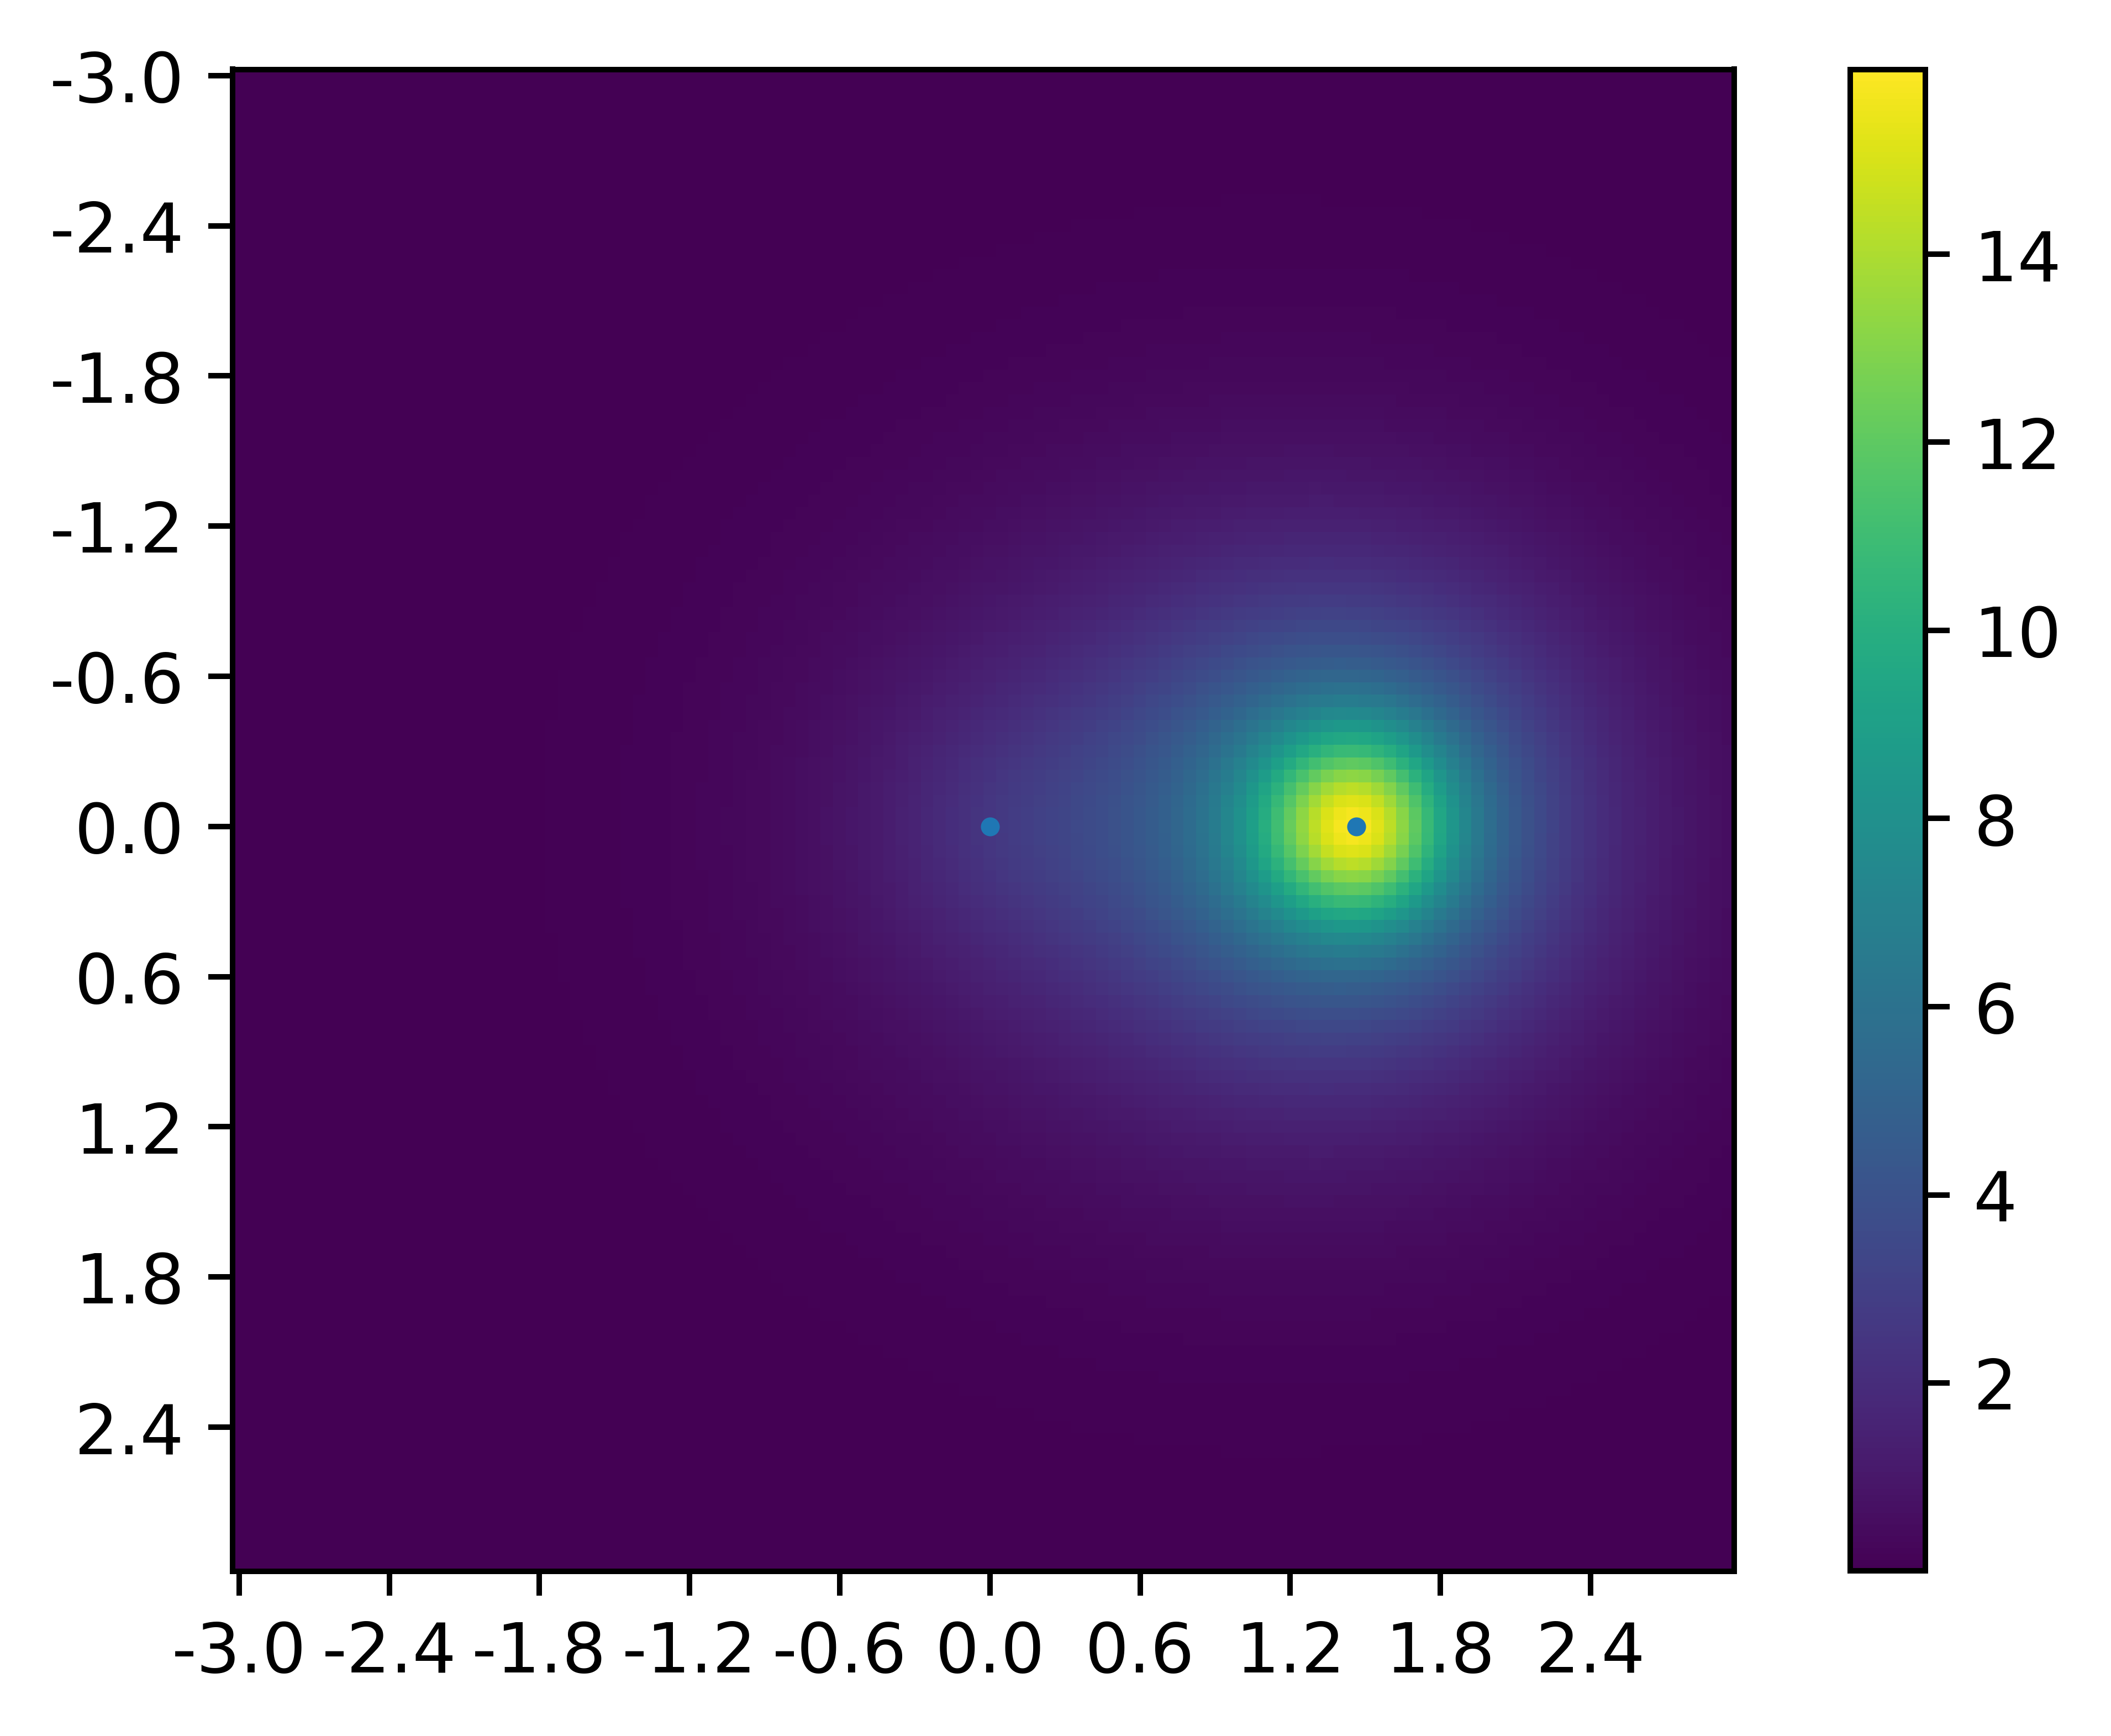

In [20]:
###HW1 display
print("-------------------------------------------------------")
H2molecular()
print("-------------------------------------------------------")
HeH()

converged SCF energy = -0.40332644165448
converged SCF energy = -0.837130298220893
converged SCF energy = -1.01949705597457
converged SCF energy = -1.09456409815733
converged SCF energy = -1.11687114045084
converged SCF energy = -1.11169589336867
converged SCF energy = -1.09200584902587
converged SCF energy = -1.06457687812843
converged SCF energy = -1.03306085702774
converged SCF energy = -0.999643227908301
converged SCF energy = -0.965793676028982
converged SCF energy = -0.932544523689493
converged SCF energy = -0.900603586576966
converged SCF energy = -0.870429788391984
converged SCF energy = -0.842297036629436
converged SCF energy = -0.81634415921746
converged SCF energy = -0.792610663232621
converged SCF energy = -0.771062501661368
converged SCF energy = -0.75161245735853
converged SCF energy = -0.734137730606413
converged SCF energy = -0.718495190682177
converged SCF energy = -0.704533682404784
converged SCF energy = -0.692102806548966
converged SCF energy = -0.681058200729535
co

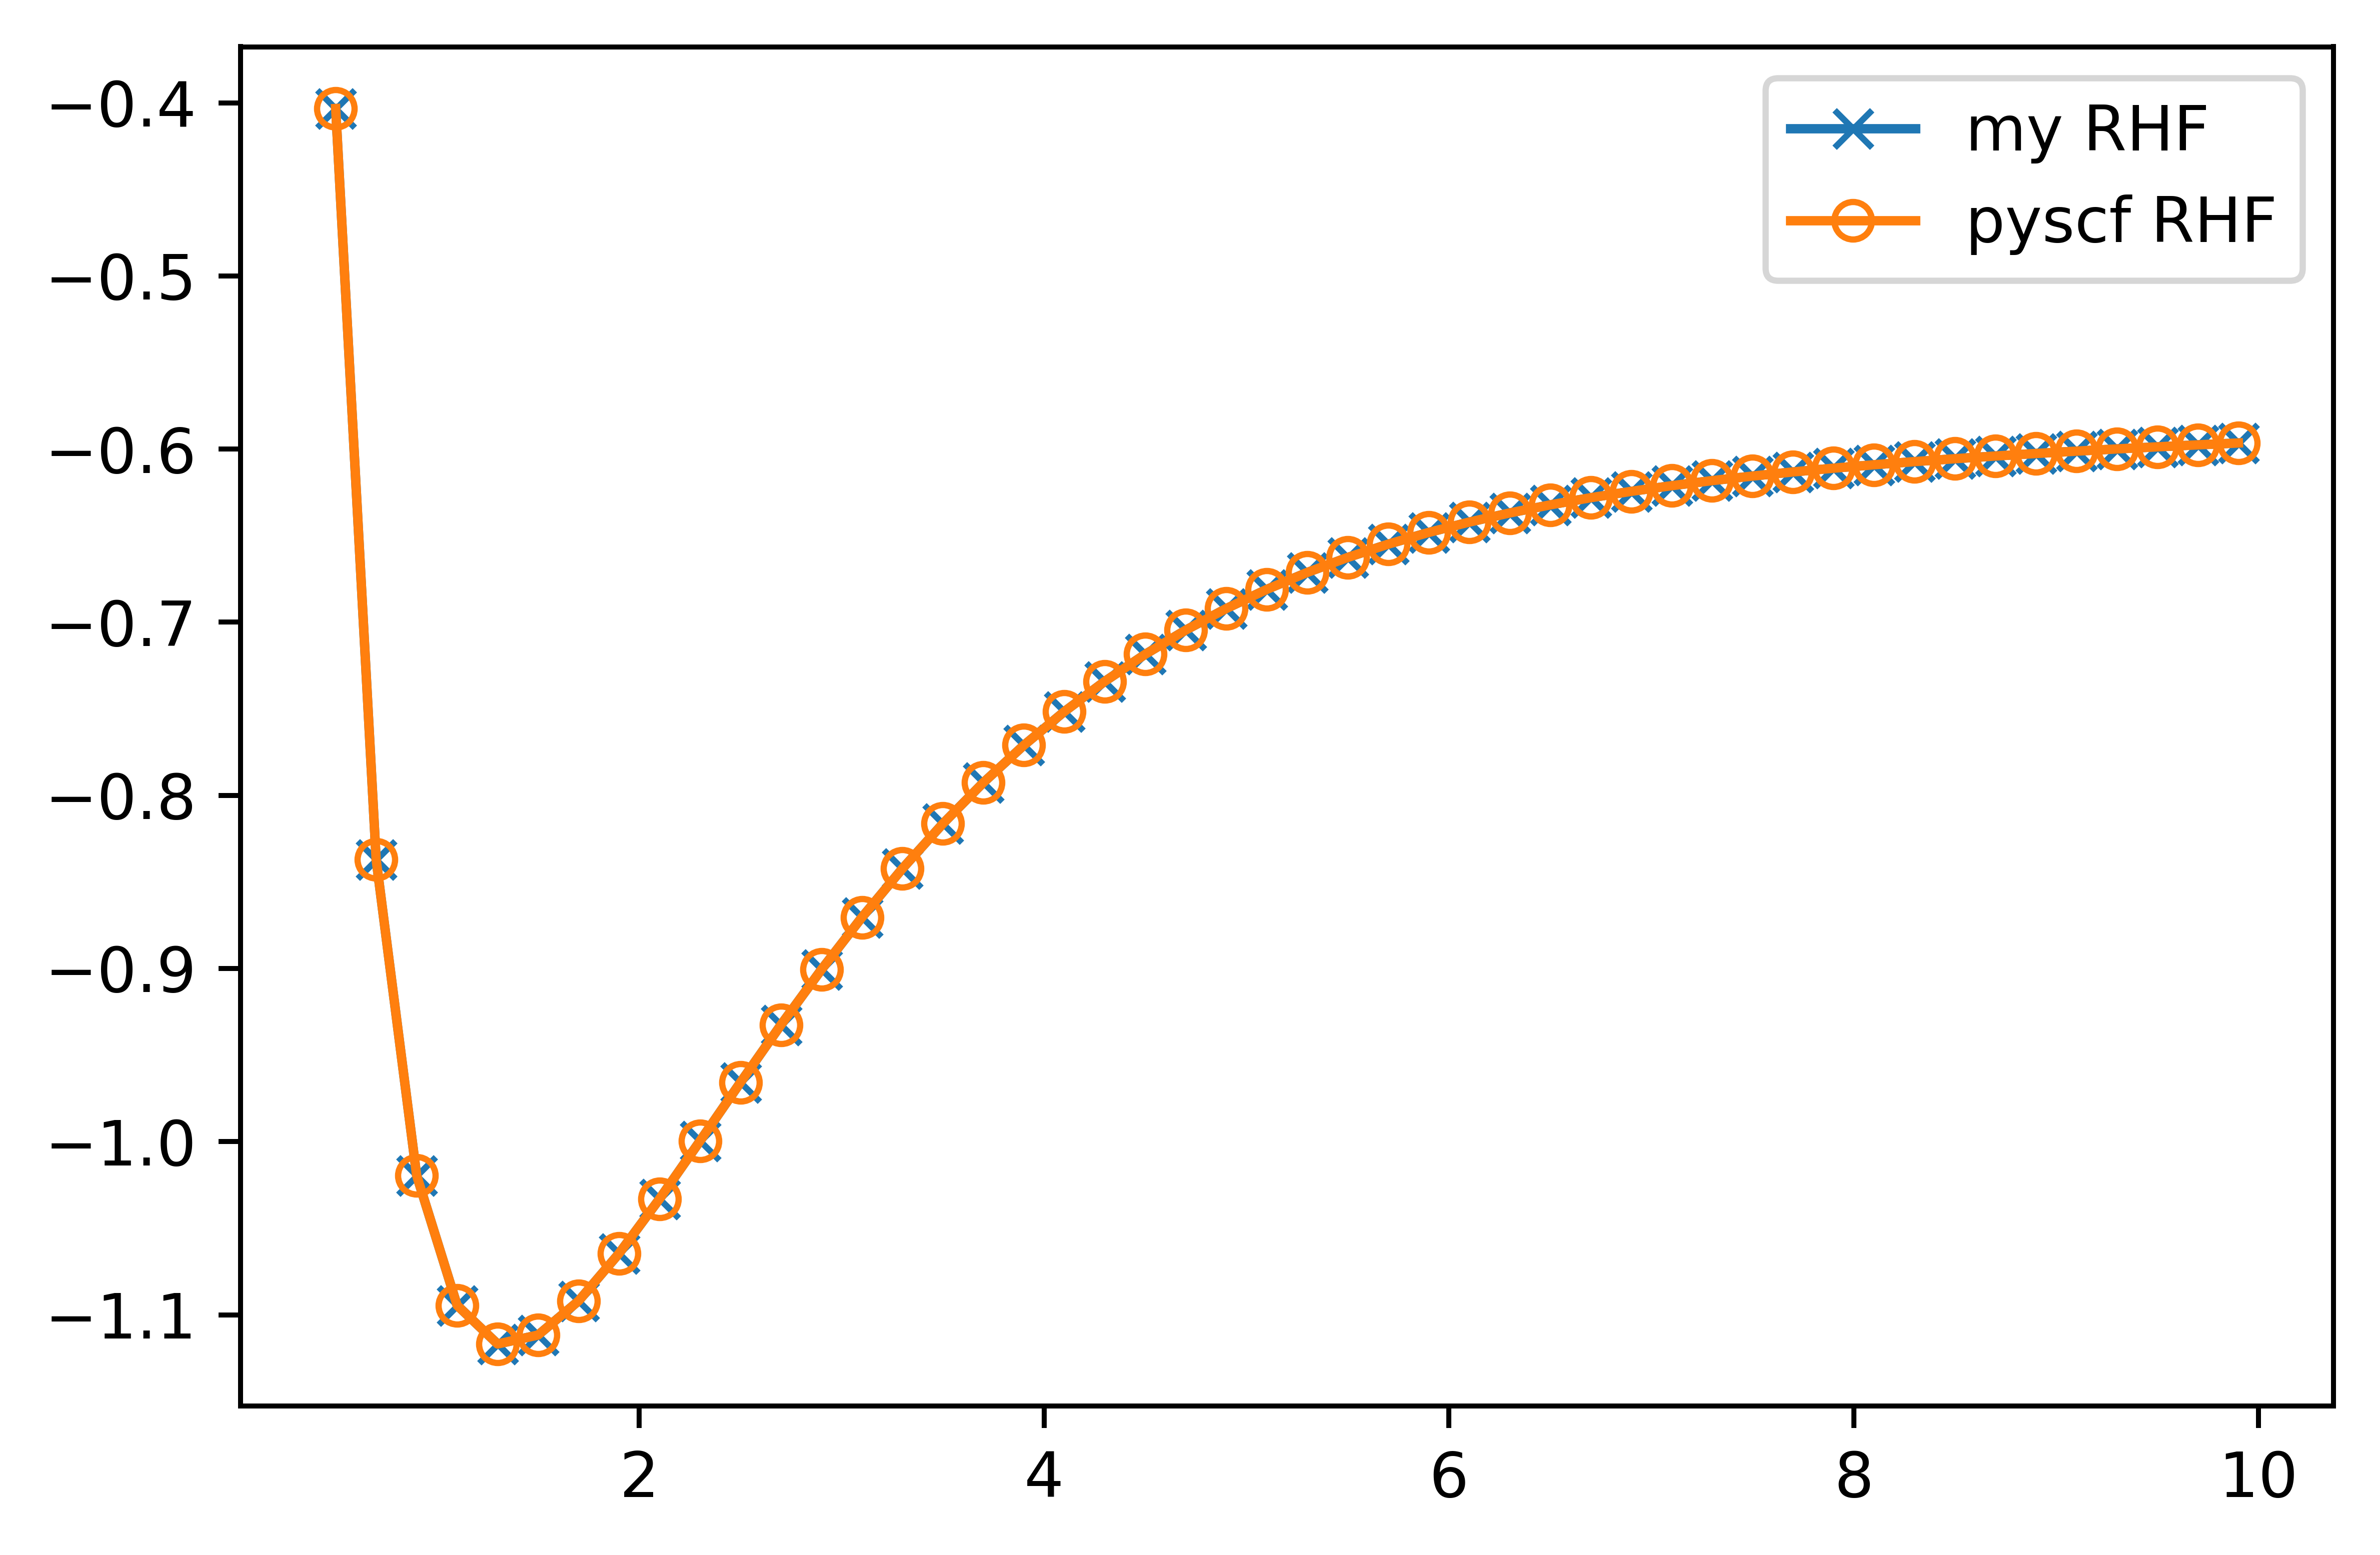

In [37]:
def compare_mine_pyscf(a1,a2,ra=np.arange(0.5,10,0.2),c=0):
    emy=[]
    epy=[]
    for x in ra:
        mol = gto.M (unit = 'Bohr',atom = '''%s 0 0 0 ;%s %f 0 0 '''%(a1,a2,x),basis = 'sto-3g',charge=c)
        rhf_py = scf.RHF (mol).run()
        epy.append(rhf_py.e_tot)
        if set([a1,a2])==set(["H","He"]):
            (e_rhf_my,)=Solver(N=2,phi=[phiH,phiHe],R=[RH,x],Z=[1,2],output=False)
        elif set([a1,a2])==set(["H","H"]):
            (e_rhf_my,p)=Solver(N=2,phi=[phiH,phiH],R=[RH,x],Z=[1,1],output=False)
        emy.append(e_rhf_my)
    plt.plot(ra,emy,label='my RHF',marker="x")
    plt.plot(ra,epy,label='pyscf RHF',marker="o",markerfacecolor='none')
    plt.legend()
    plt.savefig('compare_%s%s.png'%(a1,a2))
    plt.show()
compare_mine_pyscf("H","H")

The result of my RHF and RHF in pyscf is exactly the same.

In [21]:
def energy_curve_compare_pyscf(a1,a2,ra=np.arange(0.5,10,0.2),c=0):
    erhf=[]
    eccsd=[]
    euhf=[]
    emp=[]

    epbe=[]
    elda=[]
    epbe0=[]

    e=[[] for i in range(len(ra))]
    for x in ra:
        mol = gto.M (unit = 'Bohr',atom = '''%s 0 0 0 ;%s %f 0 0 '''%(a1,a2,x),basis = 'sto-3g',charge=c)

        rhf_h2 = scf.RHF (mol).run()
        erhf.append(rhf_h2.e_tot)

        uhf_h2 = scf.UHF (mol).run()
        euhf.append(uhf_h2.e_tot)

        ccsd_h2=cc.CCSD(uhf_h2).run()
        eccsd.append(ccsd_h2.e_tot)

        mp_h2=mp.MP2(uhf_h2).run()
        emp.append(mp_h2.e_tot)

        print(x)
        mol1 = pyscf.M(unit = 'Bohr',
            atom = '%s 0 0 0; %s %f 0 0'%(a1,a2,x), 
            basis = 'sto-3g',charge=c
        )

        mf = mol1.KS()
        mf.xc = 'pbe'
        epbe.append(mf.kernel())
        mf.xc = 'pbe0'
        epbe0.append(mf.kernel())
        mf.xc = 'lda'
        elda.append(mf.kernel())
        
    plt.plot(ra,erhf,label="rhf",linestyle="--",marker="x")
    plt.plot(ra,euhf,label="uhf",linestyle="--",marker="o")
    plt.plot(ra,eccsd,label="ccsd",linestyle="--",marker="+")
    plt.plot(ra,emp,label="mp",linestyle="--",marker="*")
    plt.plot(ra,epbe,label="pbe",marker="<")
    plt.plot(ra,epbe0,label="pbe0",marker=">")
    plt.plot(ra,elda,label="lda",marker="^")
    plt.legend()
    plt.savefig("Energyof%s%s.png"%(a1,a2))
    plt.show()

converged SCF energy = -2.84183649928172
converged SCF energy = -0.40332644165448
converged SCF energy = -0.40332644165448  <S^2> = 0  2S+1 = 1
E(CCSD) = -0.4107884754914796  E_corr = -0.007462033836999647
E(MP2) = -0.408954578475372  E_corr = -0.00562813682089184
0.5
converged SCF energy = -0.429063574625594
converged SCF energy = -0.433744855847274
converged SCF energy = -0.294600194958273
converged SCF energy = -0.837130298220893
converged SCF energy = -0.837130298220893  <S^2> = 0  2S+1 = 1
E(CCSD) = -0.8463259979971762  E_corr = -0.009195699776283478
E(MP2) = -0.843843580281378  E_corr = -0.00671328206048493
0.7
converged SCF energy = -0.863091029339791
converged SCF energy = -0.867827403410298
converged SCF energy = -0.730419682687657
converged SCF energy = -1.01949705597457
converged SCF energy = -1.01949705597457  <S^2> = -4.4408921e-16  2S+1 = 1
E(CCSD) = -1.031043064447577  E_corr = -0.01154600847300972
E(MP2) = -1.0276243484446  E_corr = -0.00812729247003546
0.89999999999999

E(CCSD) = -0.9352474003868085  E_corr = -0.2431445938378423
E(MP2) = -0.855874014005699  E_corr = -0.163771207456733
4.899999999999999
converged SCF energy = -0.855837798503575
converged SCF energy = -0.822748516935488
converged SCF energy = -0.725572498744811
converged SCF energy = -0.681058200729535
converged SCF energy = -0.681058200729535  <S^2> = 0  2S+1 = 1
E(CCSD) = -0.934590561881544  E_corr = -0.2535323611520091
E(MP2) = -0.860310550471225  E_corr = -0.179252349741691
5.099999999999999
converged SCF energy = -0.849800105061321
converged SCF energy = -0.815440193909685
converged SCF energy = -0.719108104470399
converged SCF energy = -0.671263975501551
converged SCF energy = -0.671263975501551  <S^2> = 2.220446e-16  2S+1 = 1
E(CCSD) = -0.9341344269641144  E_corr = -0.2628704514625634
E(MP2) = -0.866431785005821  E_corr = -0.19516780950427
5.299999999999999
converged SCF energy = -0.844622702632601
converged SCF energy = -0.809098400988706
converged SCF energy = -0.71355605169154

9.299999999999997
converged SCF energy = -0.81891864731582
converged SCF energy = -0.772050267016
converged SCF energy = -0.686014799646016
converged SCF energy = -0.598721320108732
converged SCF energy = -0.598721320108733  <S^2> = 0  2S+1 = 1
E(CCSD) = -0.2638208040140169  E_corr = 0.3349005160947154
E(MP2) = -1.1295897545928  E_corr = -0.530868434484065
9.499999999999998
converged SCF energy = -0.818853234211828
converged SCF energy = -0.771699929768243
converged SCF energy = -0.685946130067909
converged SCF energy = -0.597578647868962
converged SCF energy = -0.597578647868963  <S^2> = -4.4408921e-16  2S+1 = 1
E(CCSD) = -0.2616504638480373  E_corr = 0.3359281840209251
E(MP2) = -1.14342295285468  E_corr = -0.545844304985716
9.699999999999998
converged SCF energy = -0.818802670453092
converged SCF energy = -0.771376658911479
converged SCF energy = -0.685893226118311
converged SCF energy = -0.596493464586981
converged SCF energy = -0.596493464586981  <S^2> = -4.4408921e-16  2S+1 = 1
E(

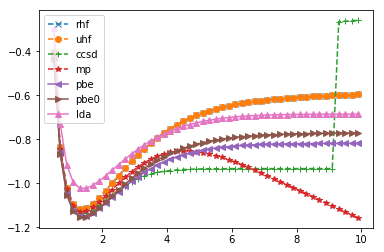

In [10]:
energy_curve_compare_pyscf("H","H")

converged SCF energy = -1.4457671456645
converged SCF energy = -1.44576714566535  <S^2> = -4.4408921e-16  2S+1 = 1
E(UCCSD) = -1.451963843034596  E_corr = -0.006196697369249841
E(UMP2) = -1.45071551736254  E_corr = -0.0049483716971899
0.5
converged SCF energy = -1.46814647872841
converged SCF energy = -1.47396443736656
converged SCF energy = -1.29567161298586
converged SCF energy = -2.23893340847113
converged SCF energy = -2.23893340847296  <S^2> = 4.4408921e-16  2S+1 = 1
E(UCCSD) = -2.246604633880169  E_corr = -0.00767122540720485
E(UMP2) = -2.24487711983235  E_corr = -0.005943711359387
0.7
converged SCF energy = -2.2625050443989
converged SCF energy = -2.26794340799023
converged SCF energy = -2.09641972810161
converged SCF energy = -2.58463857205745
converged SCF energy = -2.58463857206047  <S^2> = 4.2188475e-15  2S+1 = 1
E(UCCSD) = -2.593473516698399  E_corr = -0.008834944637925233
E(UMP2) = -2.59133289560283  E_corr = -0.00669432354235386
0.8999999999999999
converged SCF energy = -

converged SCF energy = -2.65983850343971
converged SCF energy = -2.8080742691409
converged SCF energy = -2.80807426914074  <S^2> = 1.0613732e-13  2S+1 = 1
E(UCCSD) = -2.808074795337778  E_corr = -5.261970335165152e-07
E(UMP2) = -2.80807522475696  E_corr = -9.55616214581782e-07
4.899999999999999
converged SCF energy = -2.83108550987913
converged SCF energy = -2.83655559642666
converged SCF energy = -2.65905505941923
converged SCF energy = -2.8079706699199
converged SCF energy = -2.80797066991986  <S^2> = 2.5757174e-14  2S+1 = 1
E(UCCSD) = -2.807970884499884  E_corr = -2.145800241944023e-07
E(UMP2) = -2.8079710683755  E_corr = -3.98455640733002e-07
5.099999999999999
converged SCF energy = -2.83075600525547
converged SCF energy = -2.83635260329101
converged SCF energy = -2.65848823987995
converged SCF energy = -2.80790307674022
converged SCF energy = -2.80790307674021  <S^2> = 5.5511151e-15  2S+1 = 1
E(UCCSD) = -2.807903162593479  E_corr = -8.585326390497732e-08
E(UMP2) = -2.8079032394054

converged SCF energy = -2.83598492083884
converged SCF energy = -2.65731200052291
converged SCF energy = -2.80778395923282
converged SCF energy = -2.80778395923282  <S^2> = -8.8817842e-16  2S+1 = 1
E(UCCSD) = -2.807783959232824  E_corr = 7.152597288185743e-18
E(UMP2) = -2.80778395923282  E_corr = -2.01924977014097e-17
9.299999999999997
converged SCF energy = -2.83016947716728
converged SCF energy = -2.83598491737541
converged SCF energy = -2.65731198659585
converged SCF energy = -2.80778395836458
converged SCF energy = -2.80778395836293  <S^2> = 6.4539485e-12  2S+1 = 1
E(UCCSD) = -2.807783958364513  E_corr = -1.583595736625733e-12
E(UMP2) = -2.80778395836293  E_corr = -5.00815081552392e-18
9.499999999999998
converged SCF energy = -2.8301694743749
converged SCF energy = -2.83598491558885
converged SCF energy = -2.65731197939087
converged SCF energy = -2.80778395793413
converged SCF energy = -2.80778395793296  <S^2> = 4.2474912e-12  2S+1 = 1
E(UCCSD) = -2.807783957934086  E_corr = -1.123

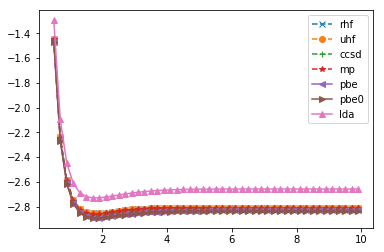

In [22]:
energy_curve_compare_pyscf("He","H",c=1)

上方是利用pyscf计算的$H_2$分子不同能量曲线的比较.我们可以看到，在不特别指定局域波函数的情况下，对于close shell的分子（离子），UHF和RHF的结果都是一样的
LDA和PBE都是纯的密度泛函方法，它们的不同在于，LDA的交换关联能只和局域密度相关，而PBE则是GGA（梯度近似）的一种，它的交换关联能不仅与局域的密度相关，而且和密度的梯度相关；而PBE0则是Hybrid functional的一种，它的交换关联能的交换能部分不完全是由密度及其导数决定的，而是密度的泛函以及由波函数得到的精确交换能的加权平均，对PBE0来说这部分交换能的密度泛函采用的是PBE的交换能。
与另外两种密度泛函相比，LDA倾向于高估分子的能量，原因是LDA是在假设均匀电子气下求得的，而电子密度的变化则会产生额外的关联，而关联能一般是负的，而对于这两种分子/离子而言，而PBE或PBE0的结果差别不大

System: uname_result(system='Linux', node='ZhouGD', release='5.4.0-74-generic', version='#83~18.04.1-Ubuntu SMP Tue May 11 16:01:00 UTC 2021', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
numpy 1.15.1  scipy 1.1.0
Date: Wed Jun  9 02:09:10 2021
PySCF version 1.7.6
PySCF path  /home/zgd/app/anaconda3/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 H      0.000000000000   0.000000000000   0.500000000000 AA    0.000000000000   0.000000000000   0.944863062283 Bohr

nuclear repulsion = 1.05835442184
number of shells = 6
number of NR pGTOs = 14
number of NR cGTOs = 10
basis = cc-pvdz
ecp =

number of shells = 6
number of NR pGTOs = 14
number of NR cGTOs = 10
basis = cc-pvdz
ecp = {}
CPU time:       305.32


******** <class 'pyscf.scf.uhf.UHF'> ********
method = UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/zgd/phy/calculate/manybody/tmpvghzu4co
max_memory 4000 MB (current use 197 MB)
number electrons alpha = 1  beta = 1
Set gradient conv threshold to 3.16228e-05
init E= -0.627105507035286
  alpha nocc = 1  HOMO = -0.827381245716561  LUMO = -0.0622065497143712
  beta  nocc = 1  HOMO = -0.573995111106267  LUMO = 0.00792014540296319
cycle= 1 E= -1.12075127105063  delta_E= -0.494  |g|= 0.0552  |ddm|= 0.463
  alpha nocc = 1  HOMO = -0.576425099847135  LUMO = 0.191793878302472
  beta  nocc = 1  HOMO = -0.561630502641879  LUMO = 0.18881359920160

DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF result = /home/zgd/phy/calculate/manybody/tmpg4cfwpo0
max_memory 4000 MB (current use 197 MB)
Set gradient conv threshold to 3.16228e-05
init E= -0.269746406849886
  HOMO = -0.829575681954954  LUMO = -0.251222146709655
cycle= 1 E= -1.10588922593453  delta_E= -0.836  |g|= 0.136  |ddm|= 0.763
  HOMO = -0.525756238394102  LUMO = 0.179013181751943
cycle= 2 E= -1.1160377665437  delta_E= -0.0101  |g|= 0.0239  |ddm|= 0.173
  HOMO = -0.548035706697542  LUMO = 0.165684808342442
cycle= 3 E= -1.1163886935276  delta_E= -0.000351  |g|= 0.00207  |ddm|= 0.0431
  HOMO = -0.548479142654092  LUMO = 0.16501973955061
cycle= 4 E= -1.11639126885562  delta_E= -2.58e-06  |g|= 0.00019  |ddm|= 0.00603
  HOMO = -0.548543420425577  LUMO = 0.165051750050586
cycle= 5 E= -1.11639130027099  delta_E= -3.14e-08  |g|= 1.76

max_memory 4000 MB (current use 197 MB)
number electrons alpha = 1  beta = 1
Set gradient conv threshold to 3.16228e-05
init E= -0.609591775085
  alpha nocc = 1  HOMO = -0.698755112684466  LUMO = -0.152464753567226
  beta  nocc = 1  HOMO = -0.473766770963394  LUMO = -0.0503780336064986
cycle= 1 E= -1.07615960154408  delta_E= -0.467  |g|= 0.0447  |ddm|= 0.434
  alpha nocc = 1  HOMO = -0.511884488436049  LUMO = 0.131815411076102
  beta  nocc = 1  HOMO = -0.494514107235311  LUMO = 0.129900761181616
cycle= 2 E= -1.07883896555412  delta_E= -0.00268  |g|= 0.0183  |ddm|= 0.0667
  alpha nocc = 1  HOMO = -0.51133390819144  LUMO = 0.125318263819146
  beta  nocc = 1  HOMO = -0.505499427677224  LUMO = 0.125102515686304
cycle= 3 E= -1.07953355778218  delta_E= -0.000695  |g|= 0.0115  |ddm|= 0.0329
  alpha nocc = 1  HOMO = -0.505267338175978  LUMO = 0.123697642391825
  beta  nocc = 1  HOMO = -0.508442057995243  LUMO = 0.123493326160657
cycle= 4 E= -1.08028583207956  delta_E= -0.000752  |g|= 0.00773  

  beta  nocc = 1  HOMO = -0.485235402756521  LUMO = 0.10023119375858
cycle= 13 E= -1.06111199769821  delta_E= -4.62e-08  |g|= 4.5e-06  |ddm|= 0.00341
  alpha nocc = 1  HOMO = -0.485251355066028  LUMO = 0.100242403932485
  beta  nocc = 1  HOMO = -0.485251393104413  LUMO = 0.100242403987416
cycle= 14 E= -1.06111199785616  delta_E= -1.58e-10  |g|= 9.97e-07  |ddm|= 0.00017
  alpha nocc = 1  HOMO = -0.485256091949252  LUMO = 0.100245603018131
  beta  nocc = 1  HOMO = -0.485256108844326  LUMO = 0.100245602641617
Extra cycle  E= -1.06111199785678  delta_E= -6.19e-13  |g|= 1.61e-07  |ddm|= 4.42e-07
converged SCF energy = -1.06111199785678  <S^2> = 3.0347391e-10  2S+1 = 1


******** <class 'pyscf.scf.hf.RHF'> ********
method = RHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'>
diis_start_cycle = 1
diis_space = 8
SCF conv_tol = 1e-09
SCF conv_tol_grad = None
SCF max_cycles = 50
direct_scf = True
direct_scf_tol = 1e-13
chkfile to save SCF res

Python 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
numpy 1.15.1  scipy 1.1.0
Date: Wed Jun  9 02:09:14 2021
PySCF version 1.7.6
PySCF path  /home/zgd/app/anaconda3/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 H      0.000000000000   0.000000000000   1.400000000000 AA    0.000000000000   0.000000000000   2.645616574391 Bohr

nuclear repulsion = 0.377983722085714
number of shells = 6
number of NR pGTOs = 14
number of NR cGTOs = 10
basis = cc-pvdz
ecp = {}
CPU time:       319.39


******** <class 'pyscf.scf.uhf.UHF'> ********
method = UHF
initial guess = minao
damping factor = 0
level_shift factor = 0
DIIS = <class 'pyscf.scf.diis.CDIIS'

cycle= 7 E= -1.0213782366004  delta_E= -1e-06  |g|= 4.3e-05  |ddm|= 0.00227
  alpha nocc = 1  HOMO = -0.49356608974243  LUMO = 0.0917153637609656
  beta  nocc = 1  HOMO = -0.493563327778754  LUMO = 0.0917153982606927
cycle= 8 E= -1.02137824040498  delta_E= -3.8e-09  |g|= 2.67e-05  |ddm|= 0.000357
  alpha nocc = 1  HOMO = -0.493519189878424  LUMO = 0.0916777040736992
  beta  nocc = 1  HOMO = -0.493519309652859  LUMO = 0.0916779807628734
cycle= 9 E= -1.02137824404766  delta_E= -3.64e-09  |g|= 1.6e-06  |ddm|= 0.000154
  alpha nocc = 1  HOMO = -0.493521160452144  LUMO = 0.0916796598979898
  beta  nocc = 1  HOMO = -0.493521173901899  LUMO = 0.0916796614599216
cycle= 10 E= -1.02137824405999  delta_E= -1.23e-11  |g|= 3.69e-07  |ddm|= 6.62e-06
  alpha nocc = 1  HOMO = -0.493521549615533  LUMO = 0.0916799418121251
  beta  nocc = 1  HOMO = -0.493521556370483  LUMO = 0.0916799424783481
Extra cycle  E= -1.02137824406034  delta_E= -3.42e-13  |g|= 2.65e-07  |ddm|= 5.72e-07
converged SCF energy = -1.

System: uname_result(system='Linux', node='ZhouGD', release='5.4.0-74-generic', version='#83~18.04.1-Ubuntu SMP Tue May 11 16:01:00 UTC 2021', machine='x86_64', processor='x86_64')  Threads 8
Python 3.7.2 (default, Dec 29 2018, 06:19:36) 
[GCC 7.3.0]
numpy 1.15.1  scipy 1.1.0
Date: Wed Jun  9 02:09:15 2021
PySCF version 1.7.6
PySCF path  /home/zgd/app/anaconda3/lib/python3.7/site-packages/pyscf

[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.000000000000 Bohr
[INPUT]  2 H      0.000000000000   0.000000000000   1.700000000000 AA    0.000000000000   0.000000000000   3.212534411761 Bohr

nuclear repulsion = 0.311280712305882
number of shells = 6
number of NR pGTOs = 14
number of NR cGTOs = 10
basis = cc-pvdz
e

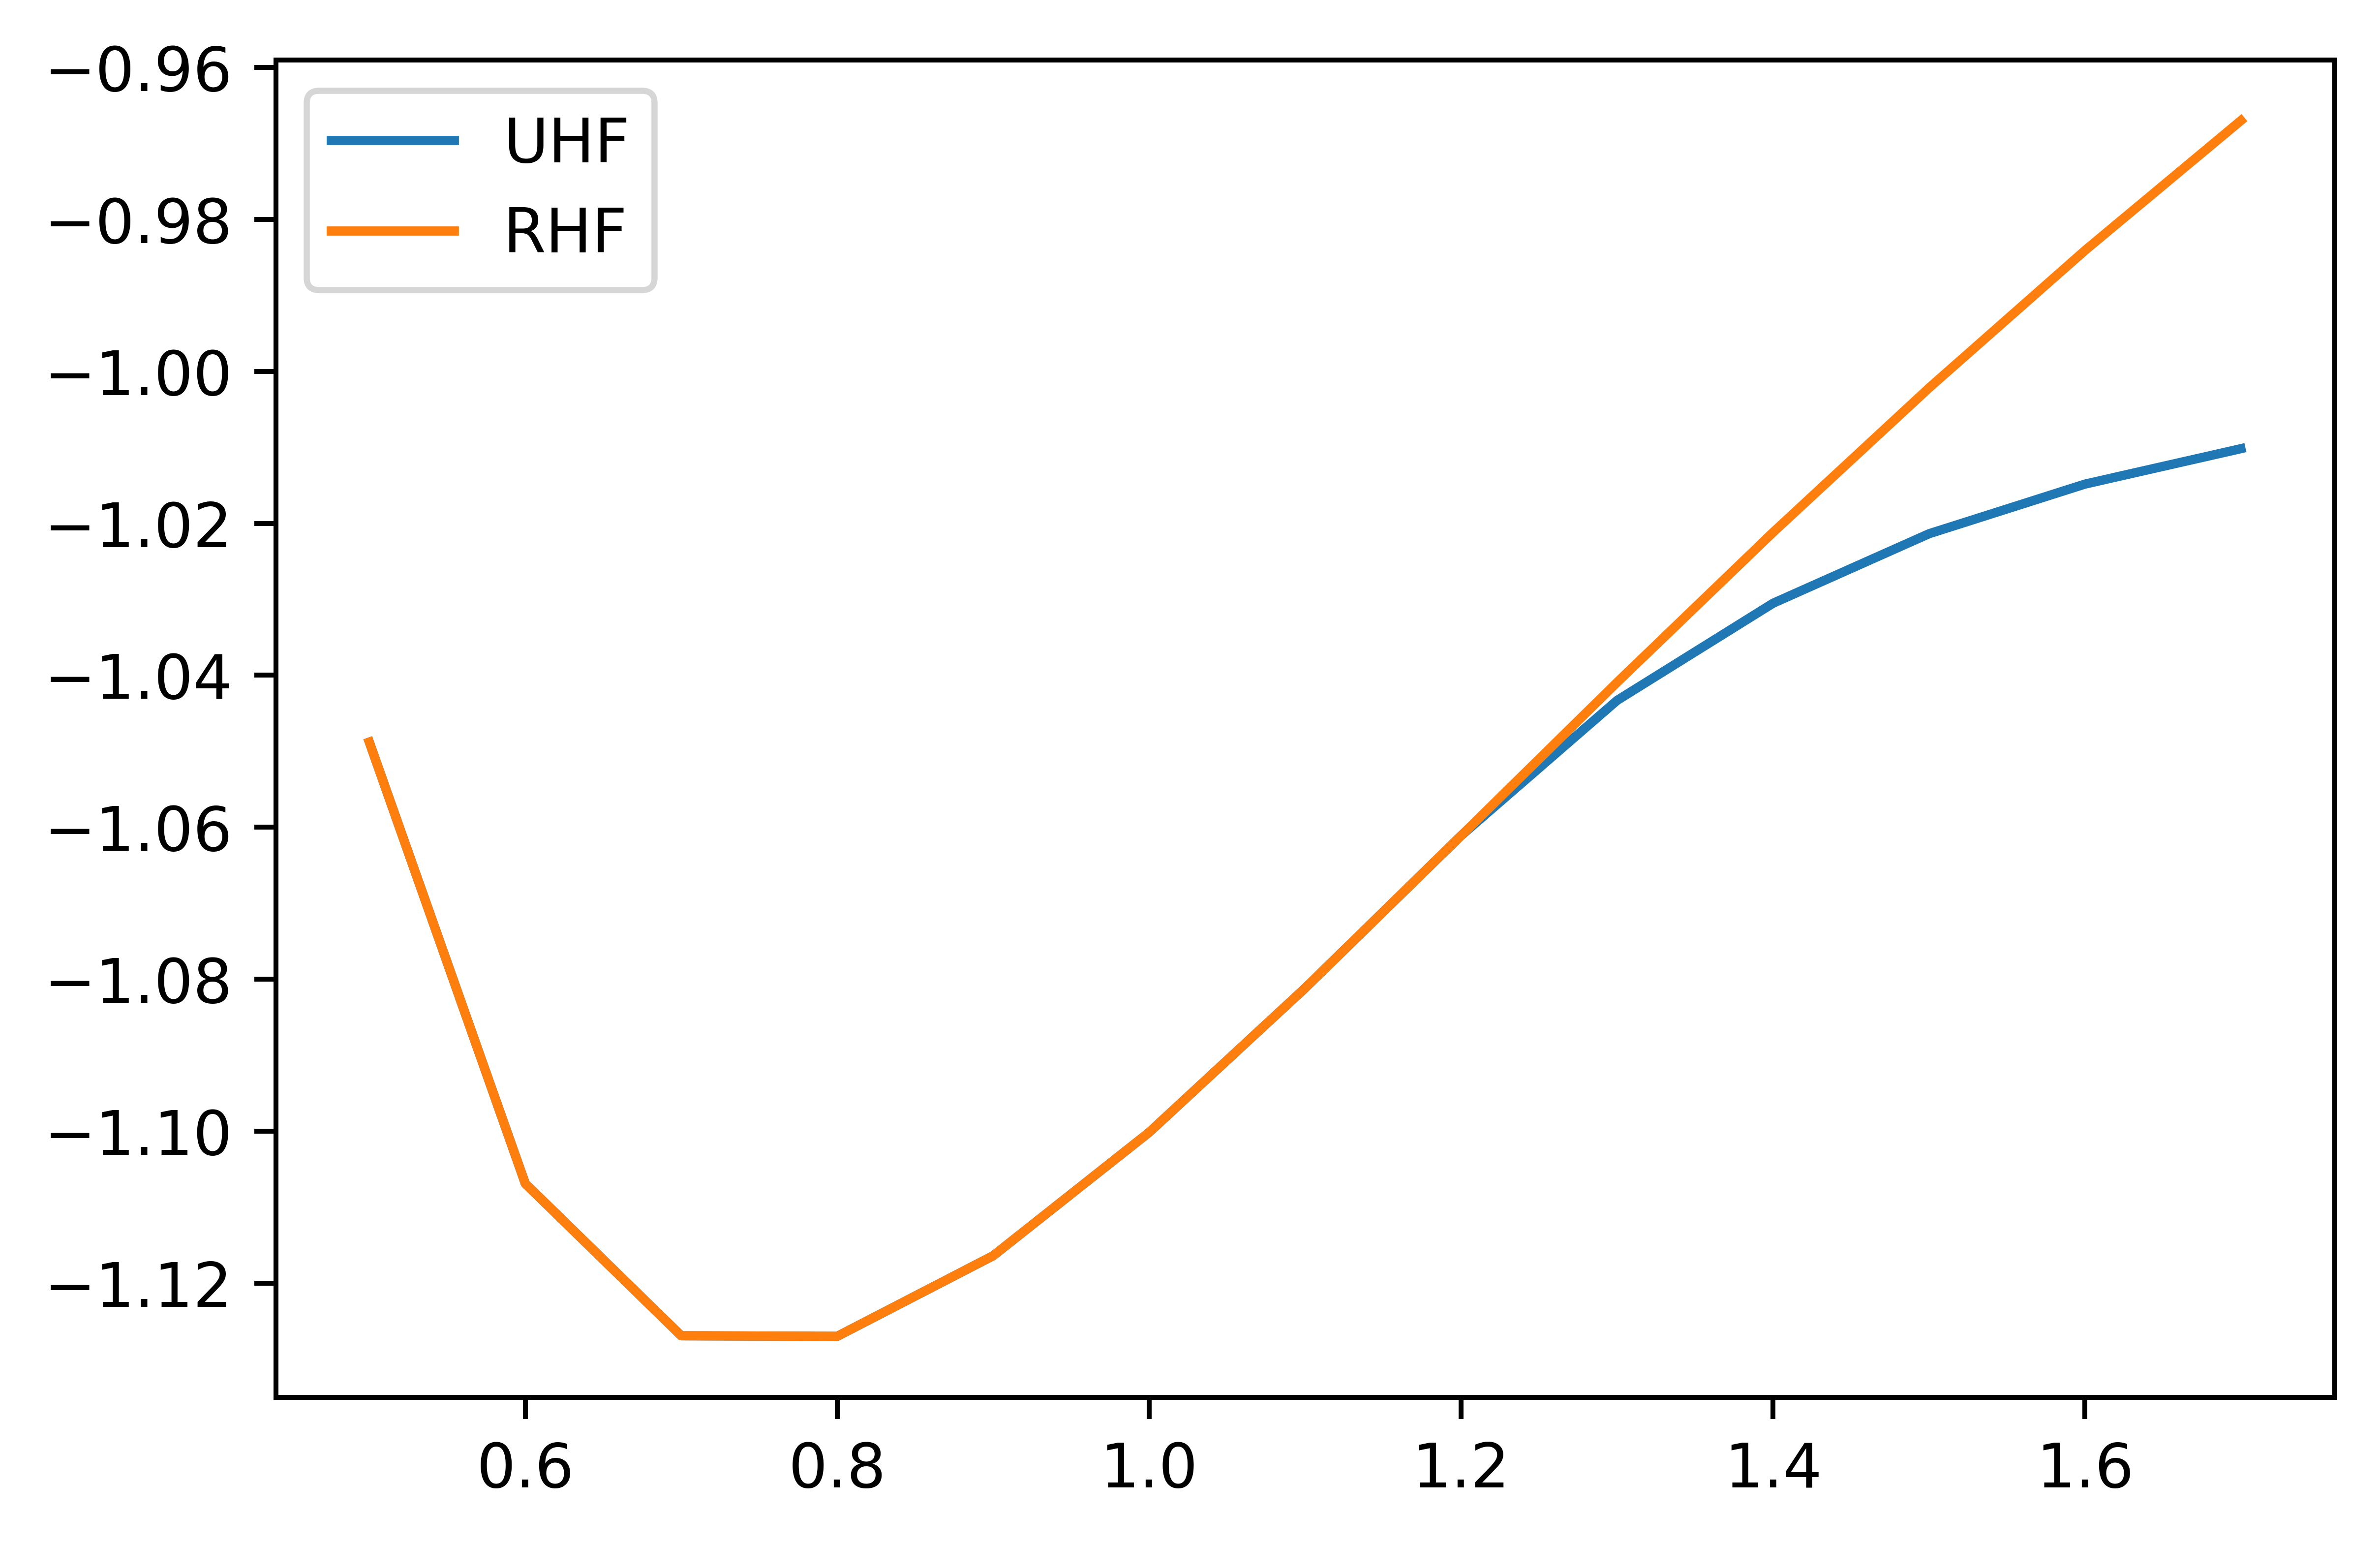

In [35]:
def uhfvsrhf():
    ra=np.arange(0.5,1.8,0.1)
    euhf=[]
    erhf=[]
    for x in ra:
        mol = gto.Mole()
        mol.verbose = 4
        mol.atom = [
            ["H", (0., 0.,  0)],
            ["H", (0., 0., x)],]
        mol.basis = 'cc-pvdz'
        mol.build()
        mf = scf.UHF(mol)
        dm_alpha, dm_beta = mf.get_init_guess()
        dm_beta[:2,:2] = 0
        dm = (dm_alpha,dm_beta)
        mf.kernel(dm)
        mf1 = scf.RHF(mol)
        dm_beta1 = mf1.get_init_guess()
        dm_beta1[:2,:2] = 0
        dm = (dm_beta1)
        mf1.kernel(dm)
        print("RHF energy=%.12f,UHF energy=%.12f"%(mf1.e_tot,mf.e_tot))
        print("--------------------------------------------")
        euhf.append(mf.e_tot)
        erhf.append(mf1.e_tot)
    plt.plot(ra,euhf,label="UHF")
    plt.plot(ra,erhf,label="RHF")
    plt.legend()
    plt.savefig("RHFUHF.png")
    plt.show()
uhfvsrhf()

在更改了initial guess之后，比较UHF和RHF，我们可以发现，在原子之间距离较小时，两个原子的轨道的overlap校小，分子的真实基态就是两个电子轨道部分相同，自旋部分组成自旋单态，但是当原子距离增大后，这就不一定是分子的真正基态了，真实的原子轨道是局域在两个原子上的，它们之间的自旋可以有不同的取向（取决于初始值）,这时可以看到UHF的能量比RHF要低，并且UHF有可能出现2S+1$\approx$2的情形————而当原子间距较小时，UHF得到的结果也是2S+1=1.